In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    data = pd.read_csv("data/Wholesale customers data.csv")
    # drop non continuous labels
    data.drop(labels=(['Channel','Region']),axis=1,inplace=True)
    print('Wholesale customers has {} samples with {} features each'.format(*data.shape))
except:
    print('Dataset could not be loaded.')

Wholesale customers has 440 samples with 6 features each


# Data preprocessing

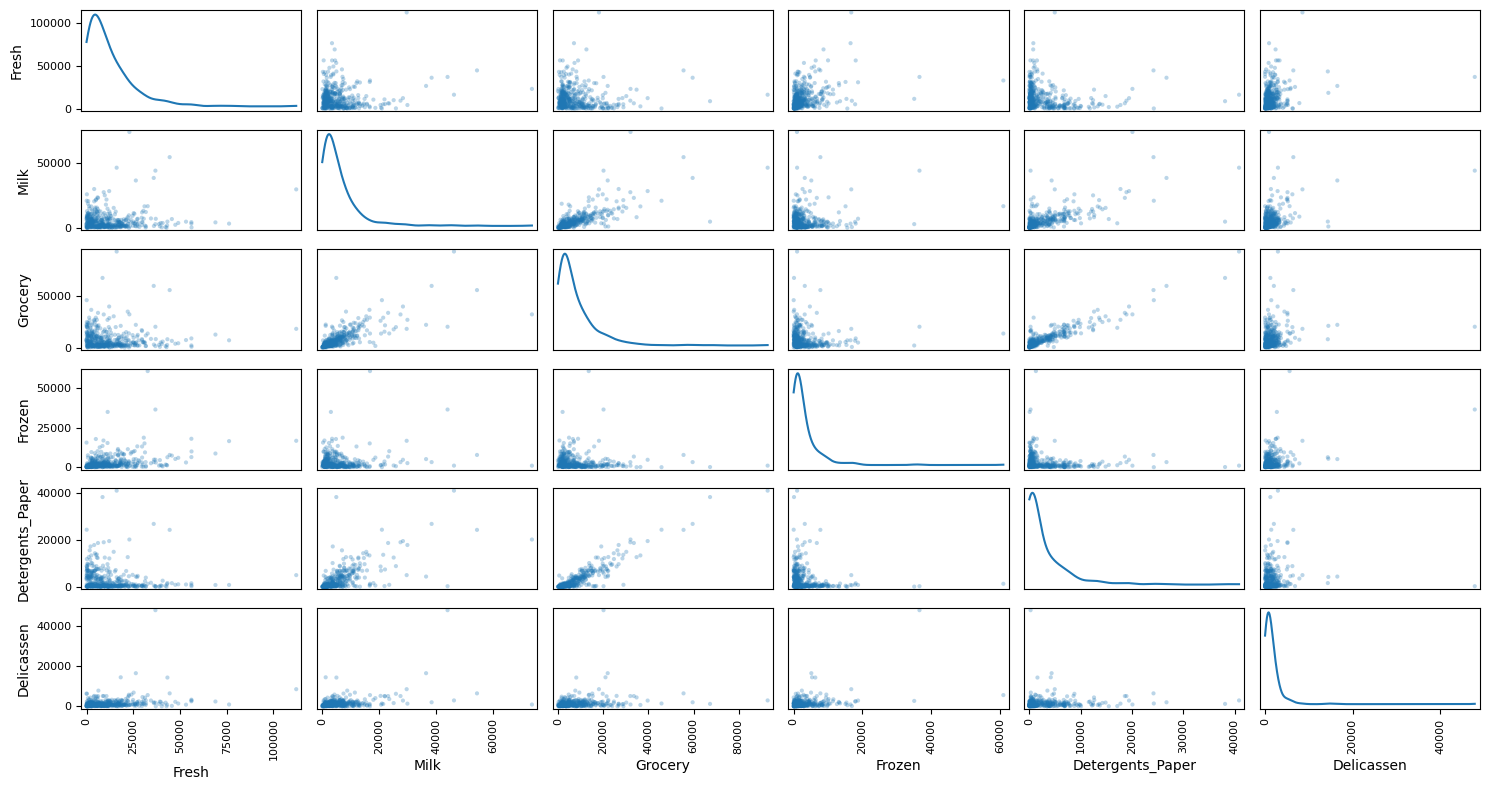

In [4]:
pd.plotting.scatter_matrix(data, alpha=0.3,figsize=(15,8),diagonal='kde' )
plt.tight_layout()

Data preprocessing

Now we will start to preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results we obtain from your analysis are significant and meaningful.

Since the ploted data is clearly left-skewed, we applied a log scale to normalize the data.

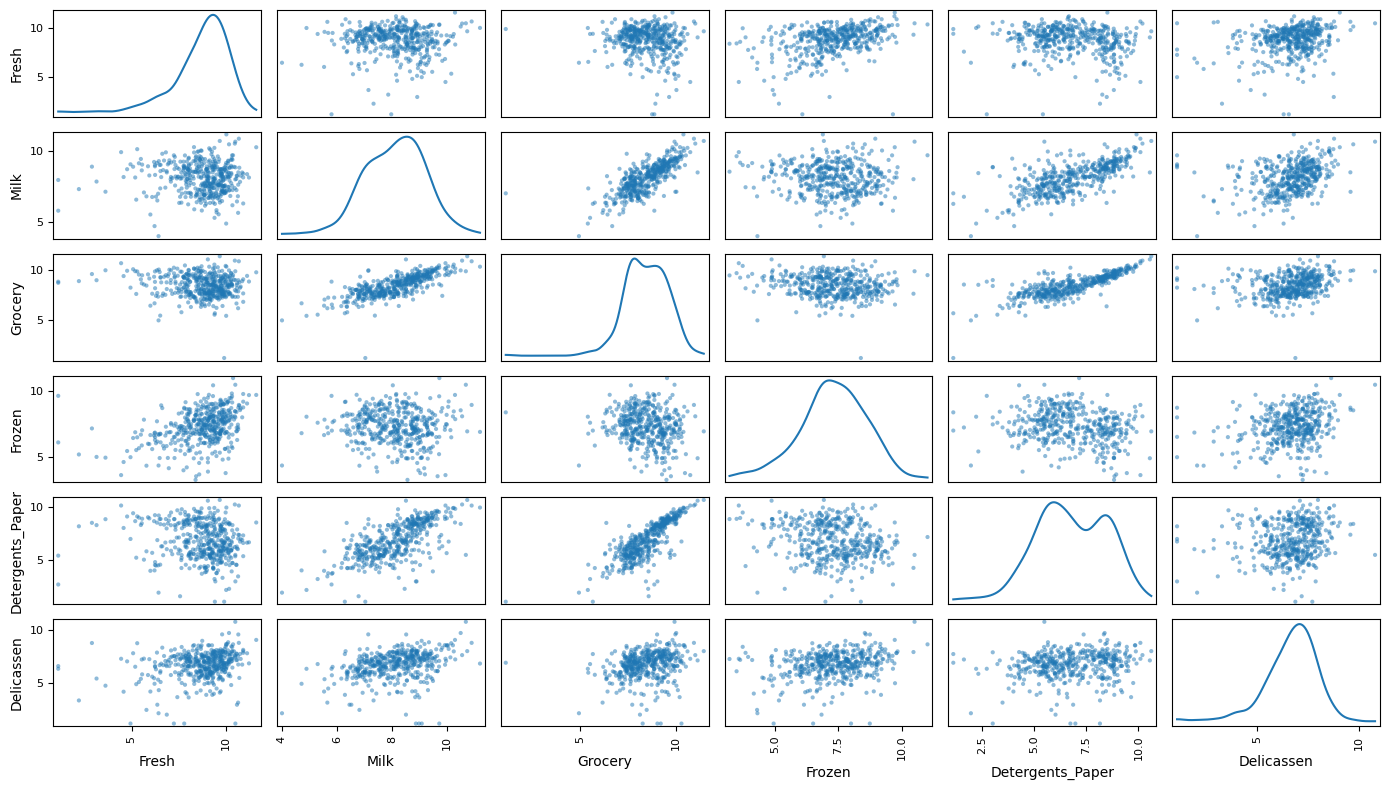

In [5]:
# Scale the data using the natural logarithm
log_data = np.log(data.copy())

pd.plotting.scatter_matrix(log_data, alpha=0.5, figsize=(14,8),diagonal='kde')
plt.tight_layout()

In [6]:
#change panda dataframe to array
log_data = log_data.iloc[np.arange(440)].values

After log scaled, each feature appear much more normal distribution.

In this plot we can see:
* Milk have corelation with Grocery, Detergents_Paper and Delicaseen.
* The pair of features with the highest correlation are Detergents_Paper and Grocery 

# Clustering

## K-Mean

In [7]:
from models.kMeans import kMeans
from sklearn.cluster import KMeans

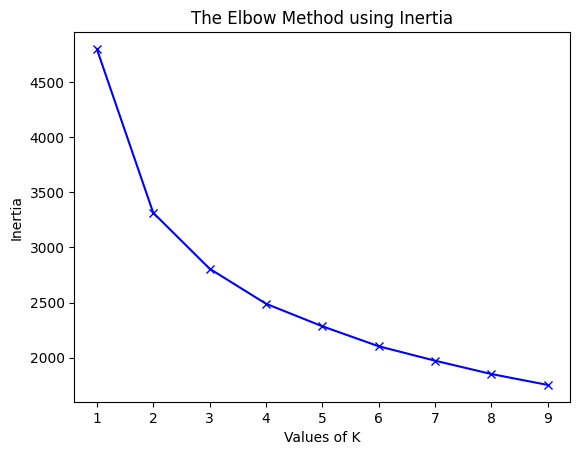

In [8]:
K = range(1, 10)
inertias = []
for k in K:
    km = KMeans(n_clusters=k).fit(log_data)
    inertias.append(km.inertia_)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

{2}


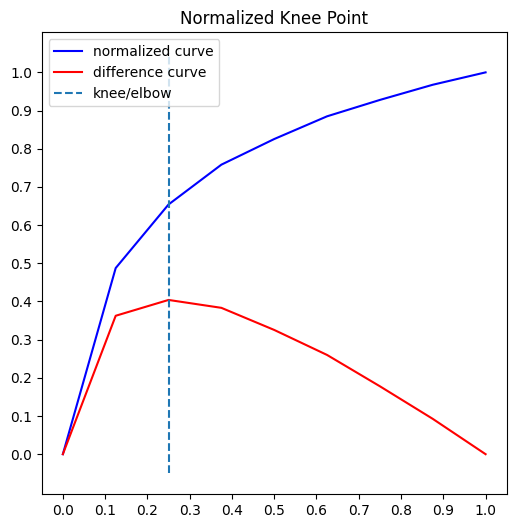

In [9]:
from kneed import KneeLocator
kneedle = KneeLocator(range(len(inertias)), 
                      inertias, 
                      S=1,
                      curve="convex",
                      direction="decreasing")
print(kneedle.all_elbows)
kneedle.plot_knee_normalized()

In [10]:
idx, centroid = kMeans(log_data, 2, 20)

## EM

In [ ]:
from models.EM import EM

In [ ]:
idx, centroid = EM(log_data, 6, 20)

## DBScan

In [47]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # To decide epsilon

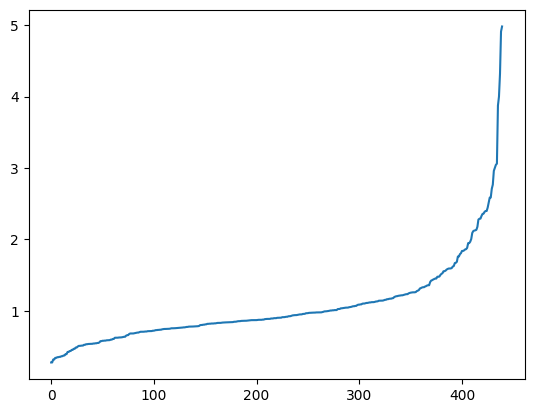

In [48]:
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit = neighbors.fit(log_data)
distances, indices = neighbors_fit.kneighbors(log_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

2.132483543403016


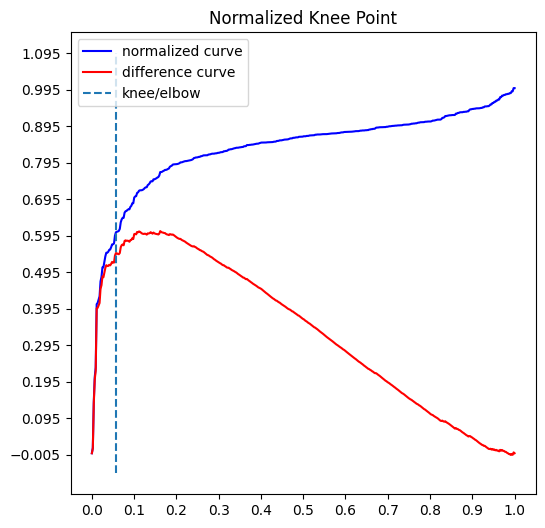

In [49]:
from kneed import KneeLocator
kneedle = KneeLocator(range(len(distances)), 
                      distances, 
                      S=1,
                      curve="convex",
                      direction="increasing")
print(kneedle.knee_y)
kneedle.plot_knee_normalized()

In [50]:
dbscan = DBSCAN(eps=2.132483543403016, min_samples=12)
idx = dbscan.fit_predict(log_data)

In [51]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(log_data, idx)
centroid = clf.centroids_

## Hierarchical clustering

In [44]:
from sklearn.cluster import AgglomerativeClustering

In [45]:
hc = AgglomerativeClustering(n_clusters=3)
idx = hc.fit_predict(log_data)

In [46]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(log_data, idx)
centroid = clf.centroids_

[[7.67344569 8.47738375 9.0322566  5.98637783 7.94739868 5.76512881]
 [8.83906157 7.35810315 7.59480588 7.60578462 5.41134878 6.49994854]
 [9.2988119  9.0322905  9.31627927 7.75113161 8.0676224  7.54001467]]


## Self-organizing map

In [7]:
from minisom import MiniSom

In [8]:
som_shape = (2, 2)
som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=6, sigma=1.0, learning_rate=0.5)
som.random_weights_init(data=log_data)
# Train SOM
som.train_random(data=log_data, num_iteration=1000, verbose=True)

# Get cluster labels
idx = np.array([som.winner(x) for x in log_data]).T
idx = np.ravel_multi_index(idx, som_shape)
centroid = som.get_weights()
centroid = np.array(centroid)
centroid = centroid.reshape(som_shape[0]*som_shape[1], 6)
print(centroid)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.2320193170462734
[[8.73084137 8.87888316 9.45344055 6.97769455 8.56998175 7.04265639]
 [9.75633975 8.21948699 8.34451875 8.08493696 6.5992899  7.25528034]
 [6.20767696 8.20138478 8.19361957 6.06609235 6.53723968 5.92435292]
 [9.46119372 7.53148431 7.8624542  7.00634557 4.84310111 5.86782508]]


## Display result 

In [9]:
_x, _y, _z = [int(0), int(1), int(3)]

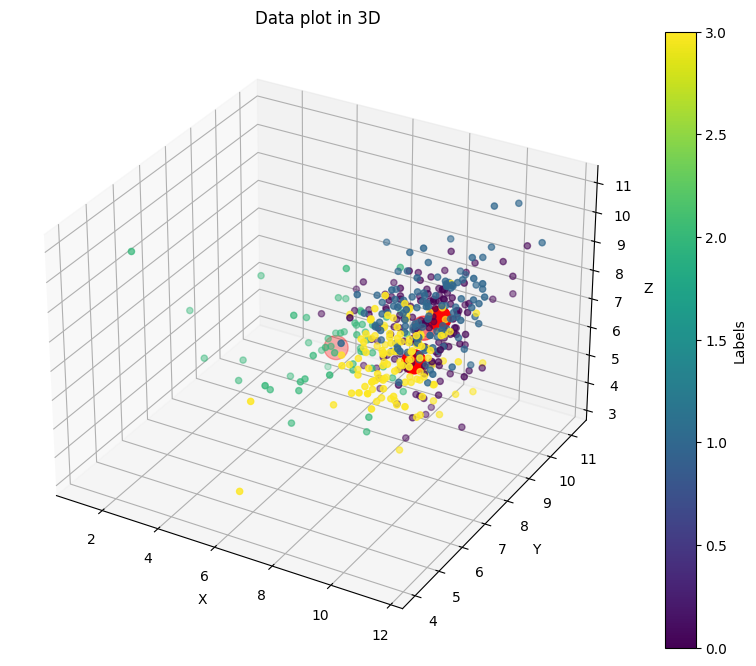

In [10]:
# Set the figure size
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract the individual columns
x = log_data[:, _x]
y = log_data[:, _y]
z = log_data[:, _z]

# Plot the 3D scatter plot with colored points based on labels
scatter = ax.scatter(x, y, z, c=idx)

# Extractac the centroid columns
x = centroid[:, _x]
y = centroid[:, _y]
z = centroid[:, _z]

ax.scatter(x, y, z, c='red', s = 300)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data plot in 3D')

# Add a colorbar for the labels
cbar = fig.colorbar(scatter)
cbar.set_label('Labels')

# Show the plot
plt.show()

## Calculate Dunn's Index

In [15]:
from scipy.spatial.distance import pdist, squareform

In [12]:
#Điền số cluster vào đây mỗi khi chạy
labels = (0, 1, 2, 3)

In [18]:
distances = pdist(log_data)

# Compute diameters of clusters
diameters = np.zeros(len(labels))
for i in labels:
    cluster_i = log_data[idx == i]
    if len(cluster_i) > 0:
        diameters[i] = np.max(pdist(cluster_i))

# Compute minimum distance between clusters
min_distances = np.min(pdist(centroid))

# DI score
dunn_index = min_distances / np.max(diameters)
print(dunn_index)

Dunn's Index:  0.23681726944265932
